## Import Libraries

In [1]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

%matplotlib inline

## Load the Data

In [2]:
df = pd.read_csv("./Higher Player.csv")

In [3]:
df.shape

(4840, 19)

In [4]:
df.head(2)

,Unnamed: 0,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,3,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,50000000


In [5]:
df.drop(columns='Unnamed: 0' , inplace = True)


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [6]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value


In [7]:
# Completeness
df.isnull().sum()

team                   0
position               0
height                 0
age                    0
appearance             0
goals                  0
assists                0
yellow cards           0
second yellow cards    0
red cards              0
goals conceded         0
clean sheets           0
minutes played         0
days_injured           0
games_injured          0
award                  0
current_value          0
highest_value          0
dtype: int64

In [8]:
# Accurecy types
df.dtypes

team                    object
position                object
height                 float64
age                    float64
appearance               int64
goals                  float64
assists                float64
yellow cards           float64
second yellow cards    float64
red cards              float64
goals conceded         float64
clean sheets           float64
minutes played           int64
days_injured             int64
games_injured            int64
award                    int64
current_value            int64
highest_value            int64
dtype: object

In [9]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
Cate_values = ['team' , 'position']
Num_values = ['height' , 'age' , 'appearance' , 'goals' , 'assists' , 'yellow cards' , 'second yellow cards' , 'red cards' , 'goals conceded' , 'clean sheets' , 'minutes played' , 'days_injured' , 'games_injured' , 'award' , 'current_value' , 'highest_value']

In [10]:
for i in Cate_values:
    print(df[i].value_counts())

team
Chelsea FC                      28
Manchester United               26
AZ Alkmaar                      26
Liverpool FC                    25
AC Monza                        25
                                ..
Club Estudiantes de La Plata     1
Defensa y Justicia               1
Club Athletico Paranaense        1
Club Atlético Tigre              1
Ulsan Hyundai                    1
Name: count, Length: 335, dtype: int64
position
Defender Centre-Back          955
Attack Centre-Forward         584
midfield-CentralMidfield      581
Goalkeeper                    442
midfield-DefensiveMidfield    432
Defender Right-Back           431
Defender Left-Back            399
midfield-AttackingMidfield    321
Attack-RightWinger            311
Attack-LeftWinger             285
midfield-RightMidfield         38
midfield-LeftMidfield          33
Attack-SecondStriker           25
Attack                          1
Defender                        1
midfield                        1
Name: count, dtype

In [11]:
type_counts = df['team'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['team'].isin(type_counts[type_counts >= 2].index)]

In [12]:
type_counts = df['position'].value_counts()

# Filter 'Type' values that appear 10 or more times
df = df[df['position'].isin(type_counts[type_counts >= 2].index)]

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [13]:
df.head(2)

,team,position,height,age,appearance,goals,assists,yellow cards,second yellow cards,red cards,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value
0,Manchester United,Goalkeeper,189.0,32.0,104,0.00000,0.00000,0.009585,0.0,0.0,1.217252,0.335463,9390,42,5,13,15000000,70000000
1,Manchester United,Defender Centre-Back,175.0,25.0,82,0.02809,0.05618,0.224719,0.0,0.0,0.000000,0.000000,6408,175,22,9,50000000,50000000


In [14]:
Cate_values

['team', 'position']

In [15]:
# one hot coding
df = pd.get_dummies(df, columns=Cate_values)

In [16]:
df.shape

(4806, 333)

#### 3. Feature selection

In [17]:
# sns.heatmap(df.corr(), annot=True);

In [18]:
correlation = df.corr()
correlation['current_value'].sort_values(ascending=False)

current_value          1.000000
highest_value          0.847563
appearance             0.421046
minutes played         0.369011
award                  0.306711
                         ...   
red cards             -0.043982
clean sheets          -0.056962
position_Goalkeeper   -0.073156
goals conceded        -0.079866
age                   -0.136490
Name: current_value, Length: 333, dtype: float64

In [19]:
# Set the correlation threshold
threshold = 0.1  # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['current_value']) > threshold]['current_value'].index
selected_features

Index(['age', 'appearance', 'goals', 'assists', 'minutes played',
       'games_injured', 'award', 'current_value', 'highest_value',
       'team_Arsenal FC', 'team_Bayern Munich', 'team_Chelsea FC',
       'team_FC Barcelona', 'team_Liverpool FC', 'team_Manchester City',
       'team_Manchester United', 'team_Paris Saint-Germain',
       'team_Real Madrid', 'team_SSC Napoli', 'team_Tottenham Hotspur'],
      dtype='object')

In [20]:
selected_features = ['age', 'appearance', 'assists', 'minutes played', 'award',
       'current_value', 'highest_value', 'team_AC Milan', 'team_AS Monaco',
       'team_Aston Villa', 'team_Atalanta BC', 'team_Chelsea FC',
       'team_Crystal Palace', 'team_Everton FC', 'team_Leeds United',
       'team_Leicester City', 'team_Newcastle United', 'team_SSC Napoli',
       'team_Southampton FC', 'team_Tottenham Hotspur']

In [21]:
df = df[selected_features]
df.head()

,age,appearance,assists,minutes played,award,current_value,highest_value,team_AC Milan,team_AS Monaco,team_Aston Villa,team_Atalanta BC,team_Chelsea FC,team_Crystal Palace,team_Everton FC,team_Leeds United,team_Leicester City,team_Newcastle United,team_SSC Napoli,team_Southampton FC,team_Tottenham Hotspur
0,32.0,104,0.000000,9390,13,15000000,70000000,False,False,False,False,False,False,False,False,False,False,False,False,False
1,25.0,82,0.056180,6408,9,50000000,50000000,False,False,False,False,False,False,False,False,False,False,False,False,False
2,30.0,63,0.017889,5031,21,40000000,80000000,False,False,False,False,False,False,False,False,False,False,False,False,False
3,30.0,68,0.000000,4762,1,25000000,70000000,False,False,False,False,False,False,False,False,False,False,False,False,False
4,28.0,70,0.032901,5471,10,15000000,35000000,False,False,False,False,False,False,False,False,False,False,False,False,False


#### 4. Prepare train and test data

In [22]:
# Prepare data
X = df.drop(['current_value'], axis=1)
y = df['current_value']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)
# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
X.shape

(4806, 19)

## Buliding the Model

In [24]:
model = LinearRegression()

In [25]:
ridge_model = Ridge()

In [26]:
lasso_model = Lasso() 

In [27]:
param_grid = {
    'alpha': [0, 0.0000003, 0.0002, 0.001, 0.01, 0.5, 1, 5]  # Regularization strength
}
grid_search_ridge = GridSearchCV(estimator=ridge_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

grid_search_lasso = GridSearchCV(estimator=lasso_model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error', 
                           verbose=1)

## Train the Model

In [28]:
# Fit the model on the training data
model.fit(X_train_scaled, y_train)

LinearRegression()

In [29]:
ridge_model.fit(X_train_scaled, y_train)

Ridge()

In [30]:
lasso_model.fit(X_train_scaled, y_train)

Lasso()

In [31]:
grid_search_ridge.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0, 3e-07, 0.0002, 0.001, 0.01, 0.5, 1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

In [32]:
grid_search_lasso.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0, 3e-07, 0.0002, 0.001, 0.01, 0.5, 1, 5]},
             scoring='neg_mean_squared_error', verbose=1)

## Test the Model

In [33]:
# Predict and evaluate the model
y_pred = model.predict(X_test_scaled)

In [34]:
y_pred_ridge = ridge_model.predict(X_test_scaled)

In [35]:
y_pred_lasso = lasso_model.predict(X_test_scaled)

In [36]:
print("Best parameters found: ", grid_search_ridge.best_params_)

# Best model
best_ridge = grid_search_ridge.best_estimator_

Best parameters found:  {'alpha': 5}


In [37]:
print("Best parameters found: ", grid_search_lasso.best_params_)

# Best model
best_lasso = grid_search_lasso.best_estimator_

Best parameters found:  {'alpha': 5}


In [38]:
y_pred_ridge_cv = best_ridge.predict(X_test_scaled)

In [39]:
y_pred_lasso_cv = best_lasso.predict(X_test_scaled)

## Interpretation of the Model

In [40]:
model.coef_

array([-2.08953100e+06, -1.14890086e+05,  3.72892940e+05,  1.96509251e+06,
       -1.65631598e+06,  1.07835127e+07,  3.64793578e+05,  2.00970113e+04,
       -6.67494589e+04,  2.20767771e+04,  1.09776843e+05,  1.86682346e+05,
        2.19442367e+02,  1.04716549e+05,  1.29521032e+05,  3.71576289e+05,
        3.39824739e+05,  2.61192740e+05,  1.03462319e+05])

In [41]:
coeff_df = pd.DataFrame(model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-2.089531e+06
appearance,-1.148901e+05
assists,3.728929e+05
minutes played,1.965093e+06
award,-1.656316e+06
highest_value,1.078351e+07
team_AC Milan,3.647936e+05
team_AS Monaco,2.009701e+04
team_Aston Villa,-6.674946e+04
team_Atalanta BC,2.207678e+04


In [42]:
coeff_df = pd.DataFrame(best_lasso.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-2.089528e+06
appearance,-1.148494e+05
assists,3.728778e+05
minutes played,1.965056e+06
award,-1.656308e+06
highest_value,1.078351e+07
team_AC Milan,3.647879e+05
team_AS Monaco,2.009195e+04
team_Aston Villa,-6.674416e+04
team_Atalanta BC,2.207156e+04


In [43]:
coeff_df = pd.DataFrame(ridge_model.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-2.089526e+06
appearance,-1.121799e+05
assists,3.728735e+05
minutes played,1.963479e+06
award,-1.653418e+06
highest_value,1.077823e+07
team_AC Milan,3.649038e+05
team_AS Monaco,2.028959e+04
team_Aston Villa,-6.625148e+04
team_Atalanta BC,2.227773e+04


In [44]:
coeff_df = pd.DataFrame(best_ridge.coef_,X.columns,columns=['Coefficient'])
coeff_df

,Coefficient
age,-2.089496e+06
appearance,-1.014255e+05
assists,3.728104e+05
minutes played,1.957090e+06
award,-1.641875e+06
highest_value,1.075718e+07
team_AC Milan,3.653426e+05
team_AS Monaco,2.105660e+04
team_Aston Villa,-6.426852e+04
team_Atalanta BC,2.307796e+04


In [45]:
print(model.intercept_) 

6543405.306971905


## Evaluating the Model 

1. Mean Square Error For Very Model

In [46]:
y_base = [y_train.mean()] * len(y_test)

In [47]:
# our benchmark model
mse_base = mean_squared_error(y_test, y_base )
print(f'Mean Squared Error of base model: {mse_base}')

Mean Squared Error of base model: 183866031782609.16


In [48]:
mse_train = mean_squared_error(y_train, model.predict(X_train_scaled))
mse_test = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train}')
print(f'Mean Squared Error for testing: {mse_test}')

Mean Squared Error for training: 33809978248962.02
Mean Squared Error for testing: 37630523755767.234


In [49]:
mse_train_ridge = mean_squared_error(y_train, best_ridge.predict(X_train_scaled))
mse_test_ridge = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train_ridge}')
print(f'Mean Squared Error for testing: {mse_test_ridge}')

Mean Squared Error for training: 33810397139839.37
Mean Squared Error for testing: 37630523755767.234


In [50]:
mse_train_lasso = mean_squared_error(y_train, best_lasso.predict(X_train_scaled))
mse_test_lasso = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error for training: {mse_train_lasso}')
print(f'Mean Squared Error for testing: {mse_test_lasso}')

Mean Squared Error for training: 33809978249852.18
Mean Squared Error for testing: 37630523755767.234


2. Mean Absolute Error For Every Model

In [51]:
# our benchmark model
mse_base = mean_absolute_error(y_test, y_base )
print(f'Mean Absolute  Error of base model: {mse_base}')

Mean Absolute  Error of base model: 7573532.12393535


In [52]:
mae_train = mean_absolute_error(y_train, model.predict(X_train_scaled))
mae_test = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train}')
print(f'Mean Absolute Error for testing: {mae_test}')

Mean Absolute Error for training: 3258290.858902079
Mean Absolute Error for testing: 3414209.646364989


In [53]:
mae_train_ridge = mean_absolute_error(y_train, best_ridge.predict(X_train_scaled))
mae_test_ridge = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train_ridge}')
print(f'Mean Absolute Error for testing: {mae_test_ridge}')

Mean Absolute Error for training: 3257155.121093202
Mean Absolute Error for testing: 3414209.646364989


In [54]:
mae_train_lasso = mean_absolute_error(y_train, best_lasso.predict(X_train_scaled))
mae_test_lasso = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error for training: {mae_train_lasso}')
print(f'Mean Absolute Error for testing: {mae_test_lasso}')

Mean Absolute Error for training: 3258287.767386665
Mean Absolute Error for testing: 3414209.646364989


3. Root Mean Squared Error For Every Model

In [55]:
# our benchmark model
print(f'Root Mean Squared  Error of base model: {np.sqrt(mse_base)}')

Root Mean Squared  Error of base model: 2752.0051097218825


In [56]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test)}')

Root Mean Squared Error for training: 5814634.833672878
Root Mean Squared Error for testing: 6134372.319623845


In [57]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train_ridge)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test_ridge)}')

Root Mean Squared Error for training: 5814670.853955482
Root Mean Squared Error for testing: 6134372.319623845


In [58]:
print(f'Root Mean Squared Error for training: {np.sqrt(mse_train_lasso)}')
print(f'Root Mean Squared Error for testing: {np.sqrt(mse_test_lasso)}')

Root Mean Squared Error for training: 5814634.833749423
Root Mean Squared Error for testing: 6134372.319623845


4. R Square For every Model

In [59]:
r2_score_train = r2_score(y_train, model.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.7834133186303316
R Square for testing: 0.7948597690784298


In [60]:
r2_score_train = r2_score(y_train, best_ridge.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.7834106352158581
R Square for testing: 0.7948597690784298


In [61]:
r2_score_train = r2_score(y_train, best_lasso.predict(X_train_scaled))
r2_score_test = r2_score(y_test, y_pred)
print(f'R Square for training: {r2_score_train}')
print(f'R Square for testing: {r2_score_test}')

R Square for training: 0.7834133186246292
R Square for testing: 0.7948597690784298


#### Predictions vs. Real Values

In [62]:
predictions = model.predict(X_test_scaled)

In [63]:
predictions_ridge = best_ridge.predict(X_test_scaled)

In [64]:
predictions_lasso = best_lasso.predict(X_test_scaled)

In [65]:
Real_Values = np.array(y_test)
#Real_Values

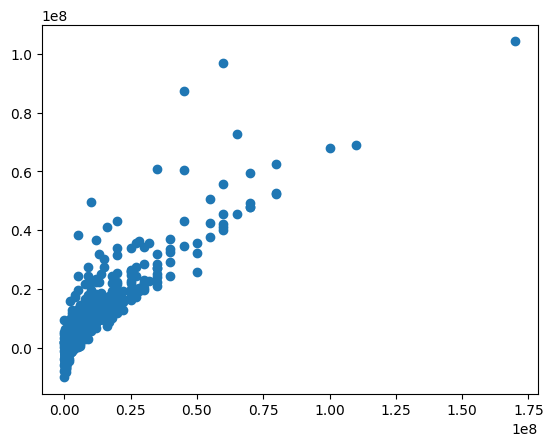

In [66]:
plt.scatter(Real_Values,predictions); 

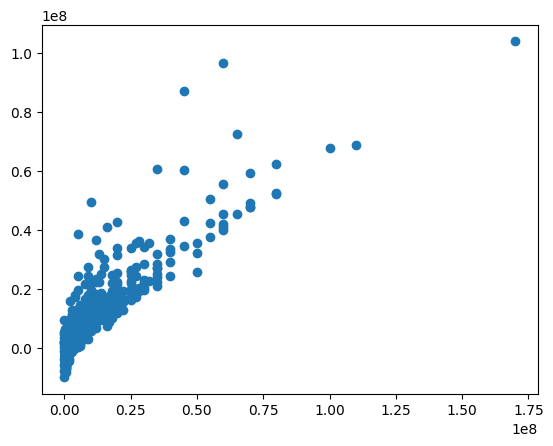

In [67]:
plt.scatter(Real_Values,predictions_ridge); 

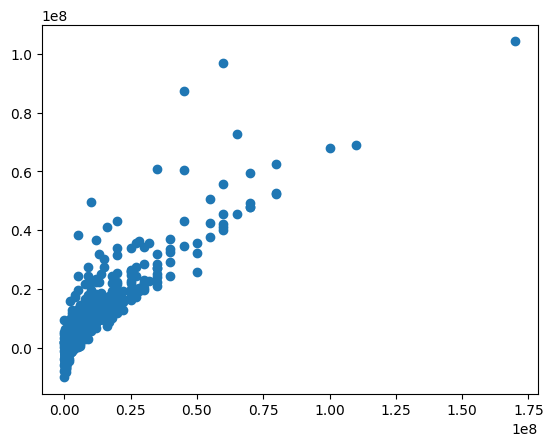

In [68]:
plt.scatter(Real_Values,predictions_lasso); 

#### Residual Histogram

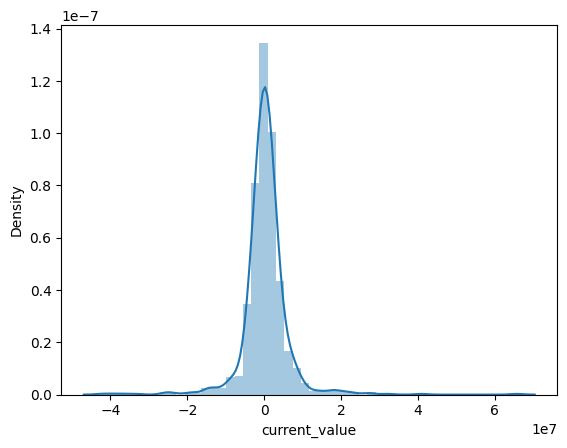

In [69]:
sns.distplot((y_test-predictions),bins=50); # it's good if we get normal distribution

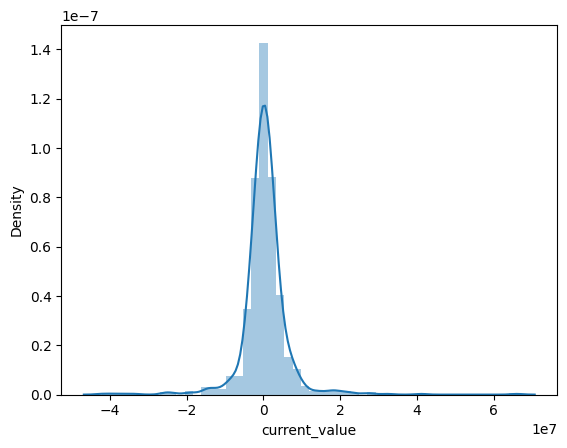

In [70]:
sns.distplot((y_test-predictions_ridge),bins=50);

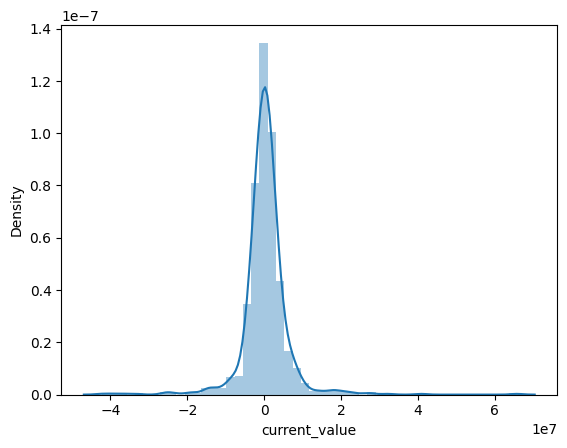

In [71]:
sns.distplot((y_test-predictions_lasso),bins=50);

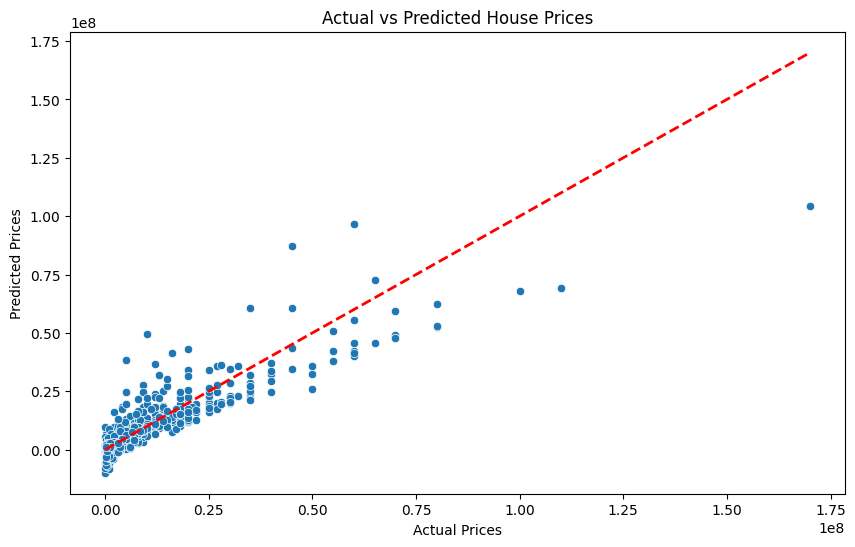

In [72]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Actual vs Predicted House Prices')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.show()